# UJM - Master DSC/MLDM - Deep Learning - TP4 -
## Building a "small" GPT

The objective of this notebook is to give an illustration on how to develop a simple generative based on a transformer architecture, which can be seen as developping a small Generative Pretrained Transformer (GPT) model.
In order to simplify the problem and makes the system more tractable, the model will work at the character level - which allows to avoid the use of additional word embeddings - and we will use a small dataset containing Shakespeare's text called tiny Shakespeare dataset.  

Goal:

    Input. A character, for example "n"

    Output. Generated text that it is written in the style of Shalespeare. For example: now that the sun hath bid adieu to light,
    And shadows stretch their fingers o’er the land,
    The stars awaken, twinkling in their flight...

This notebook is shorter version from the notebook presented by Andrej Karpathy (https://karpathy.ai) on its youtube video [Zero To Hero](https://karpathy.ai/zero-to-hero.html) on GPT. Additional sources can be found there:
Google colab for the video: https://colab.research.google.com/drive/1JMLa53HDuA-i7ZBmqV7ZnA3c_fvtXnx-?usp=sharing  
GitHub repo for the video: https://github.com/karpathy/ng-video-lecture  

## First Element: download the dataset and investigate it a bit

In [2]:
# We always start with a dataset to train on. Let's download the tiny shakespeare dataset
!wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt

--2025-12-12 13:06:08--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1115394 (1.1M) [text/plain]
Saving to: ‘input.txt.1’

input.txt.1         100%[===================>]   1.06M  --.-KB/s    in 0.05s   

2025-12-12 13:06:08 (21.5 MB/s) - ‘input.txt.1’ saved [1115394/1115394]



In [3]:
# read it in to inspect it
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

In [4]:
print("length of dataset in characters: ", len(text))

length of dataset in characters:  1115394


In [5]:
# let's look at the first 1000 characters
print(text[:1000])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you know Caius Marcius is chief enemy to the people.

All:
We know't, we know't.

First Citizen:
Let us kill him, and we'll have corn at our own price.
Is't a verdict?

All:
No more talking on't; let it be done: away, away!

Second Citizen:
One word, good citizens.

First Citizen:
We are accounted poor citizens, the patricians good.
What authority surfeits on would relieve us: if they
would yield us but the superfluity, while it were
wholesome, we might guess they relieved us humanely;
but they think we are too dear: the leanness that
afflicts us, the object of our misery, is as an
inventory to particularise their abundance; our
sufferance is a gain to them Let us revenge this with
our pikes, ere we become rakes: for the gods know I
speak this in hunger for bread, not in thirst for revenge.



In [13]:
# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


## Character encoding

In classic transformer model, one classically uses word embeddings as input, in this simplified model, we simply encode each character as a number.

In [7]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

print(encode("hii there"))
print(decode(encode("hii there")))

[46, 47, 47, 1, 58, 46, 43, 56, 43]
hii there


In [43]:
# let's now encode the entire text dataset and store it into a torch.Tensor
import torch # we use PyTorch: https://pytorch.org
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000]) # the 1000 characters we looked at earier will to the GPT look like this

torch.Size([1665]) torch.int64
tensor([ 6, 52, 30, 39, 52,  7,  0, 15, 30, 37, 37, 40,  5,  0,  6, 52, 31, 43,
        52,  7,  0,  9, 40, 39, 35, 40, 46, 43,  5,  0,  6, 52, 30, 39, 29, 52,
         7,  0,  0,  6, 52, 30, 39, 52,  7,  0, 15, 40, 48,  1, 26, 43, 30,  1,
        50, 40, 46,  8,  0,  6, 52, 31, 43, 52,  7,  0, 10, 40, 38, 38, 30, 39,
        45,  1, 55, 26,  1, 47, 26,  1,  8,  0,  6, 52, 30, 39, 29, 52,  7,  0,
         0,  6, 52, 30, 39, 52,  7,  0, 16,  1, 26, 38,  1, 31, 34, 39, 30,  3,
         1, 45, 33, 26, 39, 36,  1, 50, 40, 46,  5,  0,  6, 52, 31, 43, 52,  7,
         0, 17, 30,  1, 47, 26, 34, 44,  1, 27, 34, 30, 39,  3,  1, 38, 30, 43,
        28, 34,  5,  0,  6, 52, 30, 39, 29, 52,  7,  0,  0,  6, 52, 30, 39, 52,
         7,  0, 25, 33, 26, 45,  1, 34, 44,  1, 50, 40, 46, 43,  1, 39, 26, 38,
        30,  8,  0,  6, 52, 31, 43, 52,  7,  0, 10, 40, 38, 38, 30, 39, 45,  1,
        45, 46,  1, 45,  2, 26, 41, 41, 30, 37, 37, 30, 44,  1,  8,  0,  6, 52,
        3

## Train / validation sets construction

In [9]:
# Let's now split up the data into train and validation sets
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

## Context/history and prediction
We now construct our prediction sets from the dataset.
The idea is that given an history or context of 8 caracters, we want to predict the next one, i.e. the 9th in the sequence.

In [14]:
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [15]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


## inputs/targets construction
We now create all the pairs context/next target caracter we can build from the dataset

In [16]:
torch.manual_seed(1337)
batch_size = 4 # how many independent sequences will we process in parallel?
block_size = 8 # what is the maximum context length for predictions?

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
    for t in range(block_size): # time dimension
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
----
when input is [24] the target: 43
when input is [24, 43] the target: 58
when input is [24, 43, 58] the target: 5
when input is [24, 43, 58, 5] the target: 57
when input is [24, 43, 58, 5, 57] the target: 1
when input is [24, 43, 58, 5, 57, 1] the target: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target: 39
when input is [44] the target: 53
when input is [44, 53] the target: 56
when input is [44, 53, 56] the target: 1
when input is [44, 53, 56, 1] the target: 58
when input is [44, 53, 56, 1, 58] the target: 46
when input is [44, 53

The contexts will be given as input to the transformer

In [17]:
print(xb) # our input to the transformer

tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])


##Bigram model
We now define a bigram model to generate text. But do not expext great results, because the bigram model takes only one character to generate the next character. It is not taking into account longer dependencies.

In [18]:
import torch
import torch.nn as nn
from torch.nn import functional as F
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        super().__init__()
        # The embedding layer creates a matrix where each row is the vector embedding of an integer
        # We ask for a vector embedding of size equal to the vocab_size, this will allow us to use the embedding
        # directly to calculate logits, and afterwards probabilities
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)

    def forward(self, idx, targets=None):
        # each token directly reads off the logits for the next token from a lookup table
        # idx and targets are both (B,T) tensor of integers
        logits = self.token_embedding_table(idx) # (B,T,C) : batch, time, channel
        # The size of the time dimension represents the number of tokens we take, i.e. 8

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            # We change the shape of the logits tensor to accomodate for cross_entropy's input: nbr of tokens (B*T) x nbr of classes (C)
            logits = logits.view(B*T, C)
            # Change the shape of targets to feed it to cross_entropy
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # get the predictions
            logits, loss = self(idx)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=100)[0].tolist()))


torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)

SKIcLT;AcELMoTbvZv C?nq-QE33:CJqkOKH-q;:la!oiywkHjgChzbQ?u!3bLIgwevmyFJGUGp
wnYWmnxKWWev-tDqXErVKLgJ


In [19]:
yb.view(4*8).shape

torch.Size([32])

In [20]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)

In [21]:
batch_size = 32
for steps in range(100): # increase number of steps for better results...

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

print(loss.item())


4.65630578994751


In [22]:
print(decode(m.generate(idx = torch.zeros((1, 1), dtype=torch.long), max_new_tokens=500)[0].tolist()))


oTo.JUZ!!zqe!
xBP qbs$Gy'AcOmrLwwt
p$x;Seh-onQbfM?OjKbn'NwUAW -Np3fkz$FVwAUEa-wzWC -wQo-R!v -Mj?,SPiTyZ;o-opr$mOiPJEYD-CfigkzD3p3?zvS;ADz;.y?o,ivCuC'zqHxcVT cHA
rT'Fd,SBMZyOslg!NXeF$sBe,juUzLq?w-wzP-h
ERjjxlgJzPbHxf$ q,q,KCDCU fqBOQT
SV&CW:xSVwZv'DG'NSPypDhKStKzC -$hslxIVzoivnp ,ethA:NCCGoi
tN!ljjP3fwJMwNelgUzzPGJlgihJ!d?q.d
pSPYgCuCJrIFtb
jQXg
pA.P LP,SPJi
DBcuBM:CixjJ$Jzkq,OLf3KLQLMGph$O 3DfiPHnXKuHMlyjxEiyZib3FaHV-oJa!zoc'XSP :CKGUhd?lgCOF$;;DTHZMlvvcmZAm;:iv'MMgO&Ywbc;BLCUd&vZINLIzkuTGZa
D.?


## Self-attention

In [23]:
# self-attention!
torch.manual_seed(1337)
B,T,C = 4,8,32 # batch, time, channels
x = torch.randn(B,T,C) # we create a random input

# let's see a single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
value = nn.Linear(C, head_size, bias=False)
k = key(x)   # (B, T, 16)
q = query(x) # (B, T, 16)
wei =  q @ k.transpose(-2, -1) # (B, T, 16) @ (B, 16, T) ---> (B, T, T)

tril = torch.tril(torch.ones(T, T))
#wei = torch.zeros((T,T))
wei = wei.masked_fill(tril == 0, float('-inf'))
wei = F.softmax(wei, dim=-1)

v = value(x)
out = wei @ v
#out = wei @ x

out.shape
out

tensor([[[-1.5713e-01,  8.8009e-01,  1.6152e-01, -7.8239e-01, -1.4289e-01,
           7.4676e-01,  1.0068e-01, -5.2395e-01, -8.8726e-01,  1.9068e-01,
           1.7616e-01, -5.9426e-01, -4.8124e-01, -4.8599e-01,  2.8623e-01,
           5.7099e-01],
         [ 6.7643e-01, -5.4770e-01, -2.4780e-01,  3.1430e-01, -1.2799e-01,
          -2.9521e-01, -4.2962e-01, -1.0891e-01, -4.9282e-02,  7.2679e-01,
           7.1296e-01, -1.1639e-01,  3.2665e-01,  3.4315e-01, -7.0975e-02,
           1.2716e+00],
         [ 4.8227e-01, -1.0688e-01, -4.0555e-01,  1.7696e-01,  1.5811e-01,
          -1.6967e-01,  1.6217e-02,  2.1509e-02, -2.4903e-01, -3.7725e-01,
           2.7867e-01,  1.6295e-01, -2.8951e-01, -6.7610e-02, -1.4162e-01,
           1.2194e+00],
         [ 1.9708e-01,  2.8561e-01, -1.3028e-01, -2.6552e-01,  6.6781e-02,
           1.9535e-01,  2.8073e-02, -2.4511e-01, -4.6466e-01,  6.9287e-02,
           1.5284e-01, -2.0324e-01, -2.4789e-01, -1.6213e-01,  1.9474e-01,
           7.6778e-01],
    

In [24]:
wei[0] # for 0

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1574, 0.8426, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2088, 0.1646, 0.6266, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5792, 0.1187, 0.1889, 0.1131, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0294, 0.1052, 0.0469, 0.0276, 0.7909, 0.0000, 0.0000, 0.0000],
        [0.0176, 0.2689, 0.0215, 0.0089, 0.6812, 0.0019, 0.0000, 0.0000],
        [0.1691, 0.4066, 0.0438, 0.0416, 0.1048, 0.2012, 0.0329, 0.0000],
        [0.0210, 0.0843, 0.0555, 0.2297, 0.0573, 0.0709, 0.2423, 0.2391]],
       grad_fn=<SelectBackward0>)

Notes:
- Attention is a **communication mechanism**. Can be seen as nodes in a directed graph looking at each other and aggregating information with a weighted sum from all nodes that point to them, with data-dependent weights.
- There is no notion of space. Attention simply acts over a set of vectors. This is why we need to positionally encode tokens.
- Each example across batch dimension is of course processed completely independently and never "talk" to each other
- In an "encoder" attention block just delete the single line that does masking with `tril`, allowing all tokens to communicate. This block here is called a "decoder" attention block because it has triangular masking, and is usually used in autoregressive settings, like language modeling.
- "self-attention" just means that the keys and values are produced from the same source as queries. In "cross-attention", the queries still get produced from x, but the keys and values come from some other, external source (e.g. an encoder module)
- "Scaled" attention additional divides `wei` by 1/sqrt(head_size). This makes it so when input Q,K are unit variance, wei will be unit variance too and Softmax will stay diffuse and not saturate too much. Illustration below

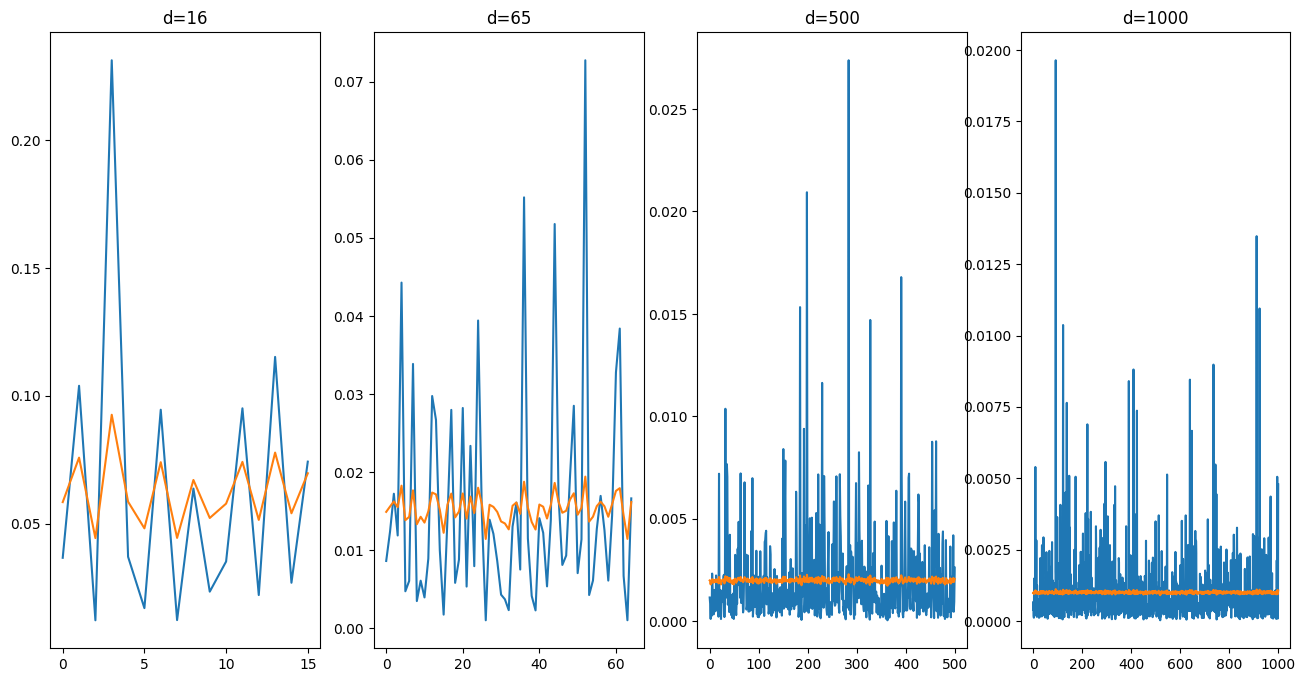

In [25]:
import matplotlib.pyplot as plt
# We apply softmax to each row of the wei matrix
# For simplicity, let's generate one row using the standard normal distribution

fig, axs = plt.subplots(1, 4, figsize=(16, 8))
for d, ax in zip([16,65,500,1000],axs):
    row_of_QKt = torch.randn(d)
    row_of_QKt
    not_normalized = F.softmax(row_of_QKt, dim=-1) #in blue
    yes_normalized = F.softmax(row_of_QKt/d**(1/2), dim=-1) #in orange
    ax.plot(not_normalized)
    ax.plot(yes_normalized)
    ax.set_title(f'd={d}')
# We see in the plot how as the number of dimensions increases, the softmax starts to concentrate
# the probability in a few maximum values (saturation).


##Ex: layer norm in 1D

In [26]:
class LayerNorm1d: # (used to be BatchNorm1d)

  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

  def __call__(self, x):
    # calculate the forward pass
    xmean = x.mean(1, keepdim=True) # batch mean
    xvar = x.var(1, keepdim=True) # batch variance
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
    self.out = self.gamma * xhat + self.beta
    return self.out

  def parameters(self):
    return [self.gamma, self.beta]

torch.manual_seed(1337)
module = LayerNorm1d(100)
x = torch.randn(32, 100) # batch size 32 of 100-dimensional vectors
x = module(x)
x.shape

torch.Size([32, 100])

In [27]:
x[:,0].mean(), x[:,0].std() # mean,std of one feature across all batch inputs

(tensor(0.1469), tensor(0.8803))

In [28]:
x[0,:].mean(), x[0,:].std() # mean,std of a single input from the batch, of its features

(tensor(-9.5367e-09), tensor(1.0000))

## Full finished code, with the transformer

You find the attention mecanism in the Head class
Try to increase the max_iters variable to get a better model

In [29]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16 # how many independent sequences will we process in parallel?
block_size = 32 # what is the maximum context length for predictions?
max_iters = 1000 # maybe got to 5000 to have first good results
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

# Instead of calculating and printing loss per batch during training,
# a better approximation of the loss is a mean over multiple batches
# the decorator @torch.no_grad reduces memory consumption
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x) # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5 # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x) # (B,T,C)
        out = wei @ v # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

# The bigram model now incorporates attention (therefore it is no longer bigram)
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd) # final layer norm
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx) # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x = self.blocks(x) # (B,T,C)
        x = self.ln_f(x) # (B,T,C)
        logits = self.lm_head(x) # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))


0.209729 M parameters
step 0: train loss 4.4116, val loss 4.4022
step 100: train loss 2.6568, val loss 2.6670
step 200: train loss 2.5090, val loss 2.5058
step 300: train loss 2.4194, val loss 2.4334
step 400: train loss 2.3501, val loss 2.3568
step 500: train loss 2.2963, val loss 2.3129
step 600: train loss 2.2410, val loss 2.2501
step 700: train loss 2.2057, val loss 2.2191
step 800: train loss 2.1633, val loss 2.1860
step 900: train loss 2.1242, val loss 2.1498
step 999: train loss 2.1018, val loss 2.1278

And my princent,'ly's neart: muth now lay.

KING friencule thal sponde'te.

LOLUCUCK:
Lat drich:
Androt, your forgulss selly, I papse,
Ands arier nat annt houl fampon glistse's
To lodich to mens to bate gothat rond benitht if it:
Edlou kineneh to bloved hing hourds andford with now ame,
An wand, lutple if if tincimion mavensst ifich lows.
 nre tne ast glon she bloyking
Hordies dotimed and for uso tholl and wiRD.

Ricl OF hotheall, issore, IS en gave, and ham.
 it hour hosw dlo;
W

In [31]:
# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
context = torch.tensor(4, dtype=torch.long, device=device).reshape(1,1)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

&s mordee;
Nos now math frevatneresinge to dake coul's sbereart on thy I dearith we to he fand iVatinen and
thing e'naare in yeears, wi I with presssted mesterisequst lentickiany drullaing wonds:
Thicras woukk at Hourdies your gomes?

And ast mressdifes-dallesul our and lier peidsent,
And bestieny snearning and nithour shis be pricie tle? hack's un ain I sof sailly it
Tio shercole onf lis onerove, Ifxst so lorve cathour,
And ust inch 'lay evien with of here
ondlat shawad hids thery and sve pnuningrans he dowerd ber?
Whow rrind, flith coen.

Tervend and my it yordath macle crent sprow
Tdealliel, lisiene the us depluke'spe.

Cegat to't it riue trows, Ie, to's fill calk.

This mally on my senearn to dasabpmeonerd.
Ritistased as of ham brist
O? I wit.

FI'MIWANV:
Fir, hom your Entonerr: that hous is impsenen'd uf dofdoblin?

CefWull ath weave, cond bexdodingnce to of hate
To he fordary thifill. on the ge, ta hat fut nlest; mord Andhamp
O, with whollish andof sprios aff litbrard,
Gold, thir

## Up to you: try to play with this model
##Maybe expand it to translate english to french


I created a dummy data called en_fr.txt

In [52]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters (tuned a bit for translation format)
batch_size = 16
block_size = 128          # translation needs more context than 32
max_iters = 5000          # 1000 is usually too small for decent results
eval_interval = 500
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.1             # a bit of regularization helps

torch.manual_seed(1337)

# Load English-French prompt-formatted dataset
# File must contain blocks like:
# <|en|>\n...\n<|fr|>\n...\n<|end|>\n\n
with open('en_fr.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# vocabulary (character-level)
chars = sorted(list(set(text)))
vocab_size = len(chars)

stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9 * len(data))
train_data = data[:n]
val_data = data[n:]

# --- Translation-focused loss masking (learn mainly on French part) ---
fr_tag = "<|fr|>\n"
fr_tag_ids = torch.tensor(encode(fr_tag), dtype=torch.long)

def find_fr_start(seq_1d: torch.Tensor, tag_ids_1d: torch.Tensor):
    """
    Finds the first index *after* the <|fr|>\n tag inside a 1D token-id sequence.
    Returns None if the tag is not found.
    """
    T = seq_1d.numel()
    L = tag_ids_1d.numel()
    for i in range(T - L + 1):
        if torch.equal(seq_1d[i:i+L], tag_ids_1d):
            return i + L
    return None

def get_batch(split):
    data_split = train_data if split == 'train' else val_data
    ix = torch.randint(len(data_split) - block_size - 1, (batch_size,))

    x = torch.stack([data_split[i:i+block_size] for i in ix])
    y = torch.stack([data_split[i+1:i+block_size+1] for i in ix])

    # loss mask: ignore loss before French begins; learn mainly on French continuation
    loss_mask = torch.zeros((batch_size, block_size), dtype=torch.float32)
    for b in range(batch_size):
        start = find_fr_start(x[b], fr_tag_ids)
        if start is not None and start < block_size:
            loss_mask[b, start:] = 1.0

    return x.to(device), y.to(device), loss_mask.to(device)

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y, M = get_batch(split)
            logits, loss = model(X, Y, loss_mask=M)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    """ one head of causal self-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)     # (B,T,head_size)
        q = self.query(x)   # (B,T,head_size)
        wei = q @ k.transpose(-2, -1) * (k.shape[-1] ** -0.5)  # (B,T,T) scaled
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)   # (B,T,head_size)
        out = wei @ v       # (B,T,head_size)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(n_embd, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)  # (B,T,n_embd)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):
    """ token-wise MLP (FFN) """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    """ Transformer block: attention + FFN, with residuals and LayerNorm """

    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class BigramLanguageModel(nn.Module):
    """ Decoder-only GPT-style model (character-level), conditioned by prompt """

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None, loss_mask=None):
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx)                          # (B,T,n_embd)
        pos_emb = self.position_embedding_table(torch.arange(T, device=idx.device))  # (T,n_embd)
        x = tok_emb + pos_emb                                              # (B,T,n_embd)
        x = self.blocks(x)                                                 # (B,T,n_embd)
        x = self.ln_f(x)                                                   # (B,T,n_embd)
        logits = self.lm_head(x)                                           # (B,T,vocab_size)

        loss = None
        if targets is not None:
            B, T, V = logits.shape
            logits_flat = logits.view(B*T, V)
            targets_flat = targets.view(B*T)

            if loss_mask is None:
                loss = F.cross_entropy(logits_flat, targets_flat)
            else:
                mask_flat = loss_mask.view(B*T)
                per_tok_loss = F.cross_entropy(logits_flat, targets_flat, reduction='none')
                loss = (per_tok_loss * mask_flat).sum() / mask_flat.sum().clamp_min(1.0)

        return logits, loss

    def generate(self, idx, max_new_tokens, temperature=0.9, top_k=50, stop_string=None):
        """
        temperature: <1 makes output more conservative, >1 more random
        top_k: restrict sampling to top_k characters
        stop_string: if provided, stop generation once this substring appears
        """
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, _ = self(idx_cond)
            logits = logits[:, -1, :] / temperature  # (B,vocab_size)

            if top_k is not None:
                v, _ = torch.topk(logits, top_k)
                logits[logits < v[:, [-1]]] = -float('inf')

            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1)
            idx = torch.cat((idx, idx_next), dim=1)

            if stop_string is not None:
                # check only last ~2*len(stop_string) characters to keep it cheap
                recent = decode(idx[0, -min(idx.shape[1], 2*len(stop_string)):].tolist())
                if stop_string in recent:
                    break
        return idx

model = BigramLanguageModel().to(device)
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    xb, yb, mb = get_batch('train')
    logits, loss = model(xb, yb, loss_mask=mb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# --- Translation test ---
# Put an English sentence inside the prompt, then let the model complete French.
test_prompt = "<|en|>\nWhere is the train station?\n<|fr|>\n"
context = torch.tensor(encode(test_prompt), dtype=torch.long, device=device).unsqueeze(0)

generated = model.generate(
    context,
    max_new_tokens=200,
    temperature=0.8,
    top_k=50,
    stop_string="<|end|>")
print(decode(generated[0].tolist()))


0.215486 M parameters
step 0: train loss 4.2766, val loss 4.2349
step 500: train loss 0.5194, val loss 2.6819
step 1000: train loss 0.0456, val loss 4.0181
step 1500: train loss 0.0126, val loss 4.9295
step 2000: train loss 0.0068, val loss 5.0854
step 2500: train loss 0.0043, val loss 5.4506
step 3000: train loss 0.0026, val loss 5.4819
step 3500: train loss 0.0018, val loss 5.9152
step 4000: train loss 0.0019, val loss 6.2068
step 4500: train loss 0.0016, val loss 6.0790
step 4999: train loss 0.0017, val loss 6.6766
<|en|>
Where is the train station?
<|fr|>
Je cit beau aujourd'hui.
<|end|>


To test if it really  or learned from the train data

In [56]:
test_prompt = "<|en|>\nWhy are you late?\n<|fr|>\n"
context = torch.tensor(encode(test_prompt), dtype=torch.long, device=device).unsqueeze(0)

In [57]:
generated = model.generate(
    context,
    max_new_tokens=200,
    temperature=0.8,
    top_k=50,
    stop_string="<|end|>")
print(decode(generated[0].tolist()))

<|en|>
Why are you late?
<|fr|>
Pourquoi es-tu en retard ?
<|end|>


The model generalizes poorly to unseen sentences because it is trained on a very small parallel dataset, leading it to memorize seen examples rather than learn a robust English to French translation mapping. For further work I will train with a large corpus.